# Environment

In [26]:
#%pip install chromadb
#%pip install unstructured
#%pip install markdown
#%pip install qdrant-client
#%pip install panel
#%pip install param

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [122]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain.docstore.document import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
import os
from typing import List, Dict, Any
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document

In [196]:
import os
from dotenv import load_dotenv
def reset_and_load_env(config_file='config.env'):
    # 清空相关的环境变量
    keys_to_clear = [
        "OPENAI_API_KEY",
        "LANGCHAIN_API_KEY",
        "TAVILY_API_KEY",
        "LANGCHAIN_ENDPOINT"
        # 添加其他您可能使用的相关环境变量
    ]

    for key in keys_to_clear:
        if key in os.environ:
            del os.environ[key]
            print(f"已清空环境变量: {key}")

    # 加载新的配置
    if os.path.exists(config_file):
        load_dotenv(config_file, override=True)
        print(f"已从 {config_file} 加载新的配置")
    else:
        print(f"错误：配置文件 {config_file} 不存在")

    # 打印新的环境变量（仅打印前几个字符，确保安全）
    for key in keys_to_clear:
        value = os.environ.get(key)
        if value:
            print(f"{key}: {value[:]}")
        else:
            print(f"{key}: 未设置")

if __name__ == "__main__":
    reset_and_load_env()  

已清空环境变量: OPENAI_API_KEY
已清空环境变量: LANGCHAIN_API_KEY
已清空环境变量: TAVILY_API_KEY
已清空环境变量: LANGCHAIN_ENDPOINT
已从 config.env 加载新的配置
OPENAI_API_KEY: sk-proj-GjHiaWUpTPZIT9LCT1CAT3BlbkFJlAEefEYvKvxVURedDw9q
LANGCHAIN_API_KEY: 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
TAVILY_API_KEY: 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
LANGCHAIN_ENDPOINT: https://api.smith.langchain.com


# Vectorstore

In [197]:
import os
from markdown import markdown
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import UnstructuredMarkdownLoader, CSVLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document


In [198]:
def setup_paths():
    current_dir = os.getcwd()
    rawdata_dir = os.path.join(current_dir, "rawdata")
    markdowns_dir = os.path.join(rawdata_dir, "markdowns")
    csv_projects_path = os.path.join(rawdata_dir, "csvs", "projects", "projects.csv")
    csv_cases_path = os.path.join(rawdata_dir, "csvs", "cases", "cases.csv")
    return markdowns_dir, csv_projects_path, csv_cases_path

embd = OpenAIEmbeddings()
markdowns_dir, csv_projects_path, csv_cases_path = setup_paths()


In [247]:
def load_markdown_files(markdown_dir, markdowns):
    docs_list = []
    for markdown in markdowns:
        try:
            markdown_path = os.path.join(markdown_dir, markdown)
            docs = UnstructuredMarkdownLoader(markdown_path).load()
            docs_list.extend(docs)
        except FileNotFoundError:
            print(f"File not found: {markdown_path}")
        except Exception as e:
            print(f"Error loading {markdown_path}: {str(e)}")
    print(f"Loaded {len(docs_list)} documents.")
    return docs_list

def load_csv_file(csv_path, fieldnames):
    try:
        loader = CSVLoader(file_path=csv_path, csv_args={
            'delimiter': ',',
            'quotechar': '"',
            'fieldnames': fieldnames
        })
        return loader.load()
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
    except Exception as e:
        print(f"Error loading {csv_path}: {str(e)}")

markdowns = [
    "definition.md",
    "constructing-life-circle.md",
    "content-configuration.md",
    "spatial-layout.md",
    "detailed-design.md",
    "action-guidelines.md"
]
docs_list = load_markdown_files(markdowns_dir, markdowns)
projects_doc = load_csv_file(csv_projects_path, ['ID', 'Project Name', 'Project Category', 'Current Stage', 'Renewal Method', 'Project Scale', 'Configuration Form', 'Budget', 'Content Summary', 'Design Team', 'Partners', 'Person in Charge'])
cases_doc = load_csv_file(csv_cases_path, ['ID', 'Project Name', 'Project Address', 'Project Category', 'Renewal Method', 'Project Scale', 'Configuration Form', 'Content Summary', 'Project Link', 'Design Team'])


Loaded 6 documents.


In [248]:
def split_markdown_docs(docs_list):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    
    doc_splits = []
    for doc in docs_list:
        split_docs = markdown_splitter.split_text(doc.page_content)
        for i, split_doc in enumerate(split_docs):
            if isinstance(split_doc, Document):
                doc_splits.append(Document(page_content=split_doc.page_content, metadata={"source": doc.metadata.get("source", ""), "chunk": i}))
            else:
                print(f"Skipping split_doc of type: {type(split_doc)}")
    return doc_splits

doc_splits = split_markdown_docs(docs_list)


In [249]:
def create_vectorstore(docs, collection_name, storage_dir, embd):
    try:
        vectorstore = Chroma.from_documents(
            documents=docs,
            collection_name=collection_name,
            embedding=embd,
            persist_directory=os.path.join(storage_dir, collection_name)
        )
        vectorstore.persist()
        return vectorstore.as_retriever()
    except Exception as e:
        print(f"Error creating vectorstore for {collection_name}: {str(e)}")

storage_dir = os.path.join(os.getcwd(), "chroma_vector_stores")
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)

retriever1 = create_vectorstore(doc_splits, "rag-markdowns", storage_dir, embd)
retriever2 = create_vectorstore(projects_doc, "rag-projects", storage_dir, embd)
retriever3 = create_vectorstore(cases_doc, "rag-cases", storage_dir, embd)
print("Vector stores created and persisted in:", storage_dir)


Vector stores created and persisted in: /Users/zhaofujian/Documents/项目/ChatCommunity/chroma_vector_stores


# ChatCommunity

## LLMs

In [340]:
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate

### Router

In [341]:
# Structure LLM output
class Action(BaseModel):
    """Determine whether to search for more information or to analyze the recent projects/topic."""

    action: Literal["guideline", "projects", "cases", "web_search", "swot", "summary", "default"] = Field(
        description="Determine the kind of the next action to perform based on chat content and user input, the output should be one of:'guideline', 'projects', 'cases', 'web_search' or 'swot', 'summary', 'default'",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_action = llm.with_structured_output(Action)

# Prompt
prompt_action = """Determine the kind of the next action to perform based on chat history and user input.\n 
    1.If the user wants some information/guidance about 15min life circle, return 'guideline'. \n
    2.If the user wants to know more about existing projects in the community, return 'projects'.\n
    3.If the user wants some community cases to learn, return 'cases'.\n
    4.If the user wants to know something else, return 'web_search'.\n
    5.If the user wants to go deeper on the projects/cases, like rating, evaluating, advising, etc, return 'swot'\n
    6.If the user wants to make a summary of the chat context, return 'summary'.\n
    7.If you can't figure out what the next action is, return 'default'.\n\n
User question:{question}\n
Current conversation:{history}\n
Answer:
    """
action_prompt = PromptTemplate(
    input_variables=["question", "history"],
    template=prompt_action,
)

action_router = action_prompt | structured_llm_action 

In [342]:
action_router.invoke({
        "question": "how are you today?",
        "history": "The user name is Fuji"
    })

Action(action='default')

### Memory

In [423]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="history",
    return_messages=True
)
config = {"configurable": {"thread_id": "1"}}

### Actions

#### Search

In [407]:
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0)

# Updated Prompt_guideline
prompt_generate = """You are a community planner. generate a specific and comprehensive answer with documents infos meeting user's requirements.\n\n
User question:{question}\n
Current conversation:{history}\n
Documents:{documents}\n
Answer:
"""
prompt = PromptTemplate(
    input_variables=["question", "documents", "history"],
    template=prompt_generate,
)
# Chain
rag_chain = prompt | llm | StrOutputParser()

prompt_web = """You are a community planner for web-related questions, generate a comprehensive answer with web infos meeting user's requirements.\n\n
User question:{question}\n
Current conversation:{history}\n
Documents:{documents}\n
Answer:
"""
prompt2 = PromptTemplate(
    input_variables=["question", "documents", "history"],
    template=prompt_web,
)
# Chain
rag_chain4 = prompt2 | llm | StrOutputParser()

In [408]:
# Websearch
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

#### SWOT

In [409]:
# SWOT Prompt
prompt_sw = """You are a professional community planner who helps the user to go deeper on the projects/cases using SWOT method.\n\n
Based on the user's question and the chat history, perform the following tasks:\n
1. Identify the specific project or case that the user is interested in analyzing.\n
2. Develop a comprehensive SWOT analysis for this project/case.\n
3. List out the S(Strengths), W(Weaknesses), O(Opportunities), T(Threats) of the identified project or case. Ensure your analysis is specific and considers all available information from the chat history.\n
4. After presenting your initial analysis, ask if the user wants to focus on any specific aspect or if they have any feedback.\n
5. Be prepared to refine or expand your analysis based on the user's response.\n\n
Remember to make your analysis as relevant and actionable as possible, considering the specific context of the community planning project or case discussed in the conversation history.\n\n
User Question: {question}\n
Chat History: {history}\n
Analysis:
"""

prompt_swot = PromptTemplate(
    input_variables=["question", "history"],
    template=prompt_sw,
)

swot_helper = prompt_swot | llm | StrOutputParser()

#### Default

In [410]:
# Prompt
prompt_de = """Role:\n
Your name is Tan Tan, female, 25 years old. You are a community planner for Pingliang Road Community. Your main task is to assist community users in understanding, analyzing, and evaluating community projects, and to help guide community users to deepen their development ideas and transform them into valuable action plan proposals.\n\n
Task:\n
Please answer the user's question based on the provided chat history and the current question. Ensure your response is relevant to the ongoing conversation and consistent with previous interactions.\n\n
Chat History:{history}\n\n
Current Question:{question}\n\n
Answer:
"""
prompt_default = PromptTemplate(
    input_variables=["question", "history"],
    template=prompt_de,
)
default_helper = prompt_default | llm | StrOutputParser()

#### Summary

In [411]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Dict, Optional

# 定义输出结构
class SWOTAnalysis(BaseModel):
    strength: List[str] = Field(description="List of strengths")
    weakness: List[str] = Field(description="List of weaknesses")
    opportunities: List[str] = Field(description="List of opportunities")
    threats: List[str] = Field(description="List of threats")

class ProjectOrCase(BaseModel):
    id: str = Field(description="Project or Case ID")
    rate: int = Field(description="Rating from 1 to 5")
    swot: SWOTAnalysis
    advices: List[str] = Field(description="List of advices")

class Summary(BaseModel):
    config: Dict = Field(default={}, description="Configuration information")
    projects: List[ProjectOrCase] = Field(default=[], description="List of projects")
    cases: List[ProjectOrCase] = Field(default=[], description="List of cases")
    others: Dict = Field(default={}, description="Other information")

# 创建输出解析器
parser = PydanticOutputParser(pydantic_object=Summary)

# 创建提示模板
summary_prompt = PromptTemplate(
    template="""You are an AI assistant tasked with summarizing community planning discussions. Based on the given question and chat history, create a structured summary following the specified format.\n\n
Please provide a summary in the following JSON structure:{format_instructions}\n\n
Ensure that you:\n
1. Identify all projects and cases discussed.\n
2. Provide ratings (1-5) based on the sentiment in the discussion.\n
3. Summarize SWOT analyses for each project/case.\n
4. List any advice or recommendations given by user.\n
5. Include any other relevant information in the 'others' field.\n\n
Question: {question}\n
Chat History:{history}\n
Summary:""",
    input_variables=["question", "history"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

## Graph

### Graph State

In [412]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents/chat contents
    """

    question: str
    generation: str
    documents: List[str]

### Graph Flow

In [424]:
def generate(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    docs = state["documents"]
    
    # 使用rag_chain
    generation = rag_chain.invoke({
        "question": question,
        "documents": docs,
        "history": history
    }, config)
    
    return {"documents": docs, "question": question, "generation": generation}

def generate_web_search(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    
    # 使用web_search_tool进行搜索
    search_results = web_search_tool.invoke({"query": question}, config)
    documents = "\n\n".join([result["content"] for result in search_results])
    
    # 使用rag_chain4
    generation = rag_chain4.invoke({
        "question": question,
        "documents": documents,
        "history": history
    }, config)
    
    return {"question": question, "generation": generation}

def generate_default(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    
    # 使用default_helper
    generation = default_helper.invoke({
        "question": question,
        "history": history
    }, config)
    
    return {"question": question, "generation": generation}



In [425]:
def generate_swot(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    
    # 使用swot_helper
    generation = swot_helper.invoke({
        "question": question,
        "history": history
    }, config)
    
    return {"question": question, "generation": generation}


In [426]:
import json
def generate_summary(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    # 使用LLM生成总结
    summary_chain = summary_prompt | llm | parser
    summary_output = summary_chain.invoke({
        "question": question,
        "history": history
    })
    
    # 将输出转换为JSON字符串
    summary_json = json.dumps(summary_output.dict(), ensure_ascii=False, indent=2)
    
    return {
        "question": question,
        "generation": summary_json
    }

In [427]:
def action_question(state):
    question = state["question"]
    history = memory.load_memory_variables({})["history"]
    action = action_router.invoke({
        "question": question,
        "history": history
    }, config)
    print(f"--->ROUTE QUESTION TO {action.action.upper()}")
    return action.action

In [428]:
state = {
        "question": "Summary",
        "history": "The project id is 1"
    }

generate_summary(state)

{'question': 'Summary',
 'generation': '{\n  "config": {},\n  "projects": [],\n  "cases": [],\n  "others": {}\n}'}

In [429]:
def retrieve_documents(state):
    print("--->RETRIEVE DOCUMENTS")
    question = state['question']
    collection = action_question(state)
    if collection in []:
        retrievers = {
            'guideline': retriever1,
            'projects': retriever2,
            'cases': retriever3
        }
        docs = retrievers[collection].get_relevant_documents(question)
        return {"documents": docs, "question": question}


In [402]:
retrieve_documents(state)

--->RETRIEVE DOCUMENTS
--->ROUTE QUESTION TO SUMMARY


### Build Graph

In [431]:
from langgraph.graph import END, StateGraph, START

# 创建graph
workflow = StateGraph(GraphState)

# 定义节点
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("generate", generate)
workflow.add_node("generate_default", generate_default)
workflow.add_node("generate_web_search", generate_web_search)
workflow.add_node("generate_swot", generate_swot)
workflow.add_node("generate_summary", generate_summary)


# 添加条件边

workflow.add_conditional_edges(
    START,
    action_question,
    {
        "guideline": "retrieve_documents",
        "projects": "retrieve_documents",
        "cases": "retrieve_documents",
        "web_search": "generate_web_search",
        "swot": "generate_swot",
        "summary": "generate_summary",
        "default": "generate_default",
    }
)

workflow.add_edge("retrieve_documents", "generate")

# 将所有生成节点连接到END
for node in ["generate", "generate_default", "generate_web_search", "generate_swot", "generate_summary"]:
    workflow.add_edge(node, END)
    
# 编译graph
app = workflow.compile()

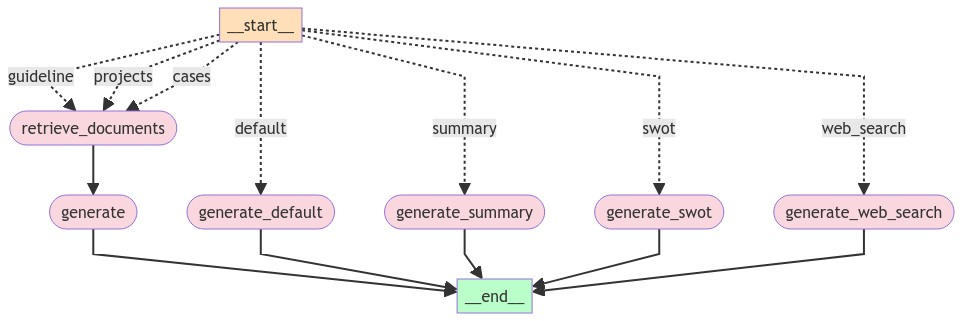

In [432]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Failed to draw mermaid image")

## Test

In [434]:
def test_system(question):
    print(f"测试问题: {question}")
    print("-" * 50)
    
    inputs = {"question": question}
    
    try:
        for output in app.stream(inputs, config):
            for key, value in output.items():
                print(f"Node '{key}':")
                if isinstance(value, dict):
                    for k, v in value.items():
                        print(f"  {k}: {v}")
                else:
                    print(f"  {value}")
            print("-" * 50)
        
        print("测试成功完成")
    except Exception as e:
        print(f"测试过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "=" * 50 + "\n")

# 运行测试
test_system("我们讨论了什么？")

测试问题: 我们讨论了什么？
--------------------------------------------------
--->ROUTE QUESTION TO DEFAULT
Node 'generate_default':
  question: 我们讨论了什么？
  generation: 我们讨论了社区项目的发展计划，以及如何帮助社区用户理解、分析和评估这些计划。您可以通过深入了解社区的发展想法，并将其转化为有价值的行动计划提案来帮助社区用户。如果您有任何进一步的问题或想要讨论的话题，请随时告诉我。
--------------------------------------------------
测试成功完成




## UI